In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed
import umap
import pandas as pd

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir
from avgn.signalprocessing.create_spectrogram_dataset import flatten_spectrograms

### Collect data

In [4]:
DATASET_ID = 'marmoset'

In [5]:
from avgn.visualization.projections import (
    scatter_projections,
    draw_projection_transitions,
)

In [103]:
df_loc =  DATA_DIR / 'syllable_dfs' / DATASET_ID / 'marmoset.pickle'

In [104]:
syllable_df = pd.read_pickle(df_loc)

In [105]:
syllable_df[:3]

,start_time,end_time,labels,call_num,pulse_num,indv,indvi,key,audio,rate,spectrogram
0,5.000000,6.688911,phee,5,0,leo,0,luna_leo_060317__h0m4s41.47470453938871,"[-0.0028140772962798664, -0.002767839704774081...",44150,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,7.008134,7.757936,phee,5,1,leo,0,luna_leo_060317__h0m4s41.47470453938871,"[-0.0017946614847837742, -0.004523495411240861...",44150,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,28.414626,29.981045,phee,6,0,leo,0,luna_leo_060317__h0m4s41.47470453938871,"[0.001508825282652068, 0.001441084705503678, 0...",44150,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [108]:
pd.DataFrame({i:[np.sum(syllable_df.indv == i)] for i in syllable_df.indv.unique()})

,leo,todd,ares,aladdin,ben,apollo,baloo,han,jasmine,angel,...,kit,nasira,copper,waylon,mango,chewie,kiwi,william,rafiki,luna
0,391,1231,875,219,290,206,98,558,237,270,...,351,2,1808,1209,28,81,5,282,7,3


### subset dataframe
- there is some noise in labelling we want to remove

Text(0.5, 1.0, 'min')

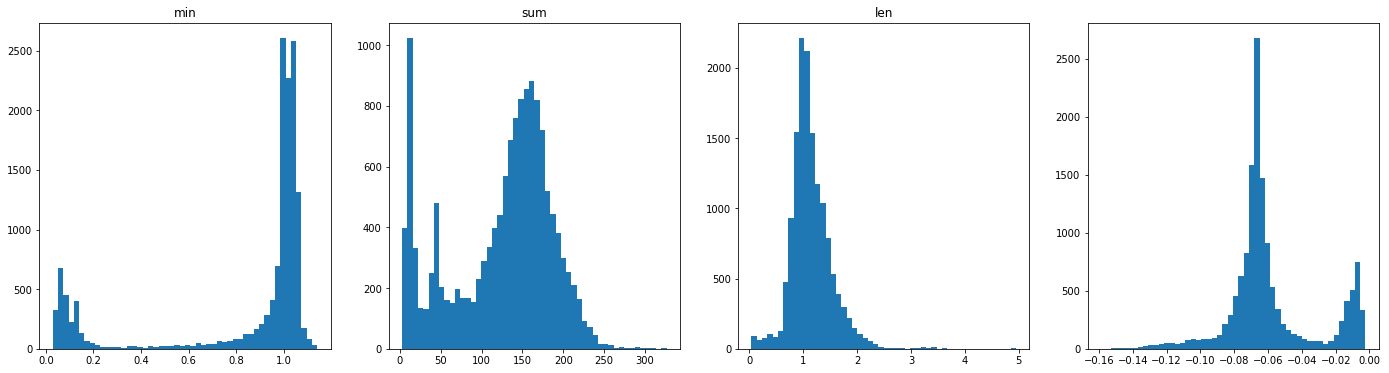

In [109]:
fig, axs = plt.subplots(ncols=4, figsize=(24,6))
axs[0].hist([np.max(i) for i in syllable_df.spectrogram.values], bins=50);axs[0].set_title('max')
axs[1].hist([np.sum(i) for i in syllable_df.spectrogram.values], bins=50);axs[1].set_title('sum')
axs[2].hist((syllable_df.end_time - syllable_df.start_time).values, bins = 50); axs[2].set_title('len')
axs[3].hist([np.min(i) for i in syllable_df.spectrogram.values], bins=50);axs[0].set_title('min')

In [114]:
indv_to_plot = [i for i in syllable_df.indv.unique() if np.sum(syllable_df.indv == i) > 500]

In [116]:
subset_df = syllable_df[
    syllable_df.indv.isin(indv_to_plot) & 
    np.array([np.sum(i) > 100 for i in syllable_df.spectrogram.values])
]

In [120]:
specs = subset_df.spectrogram.values
specs = [i/np.max(i) for i in specs if np.sum(i) > 100]
specs_flattened = flatten_spectrograms(specs)

In [129]:
subset_df[:3]

,start_time,end_time,labels,call_num,pulse_num,indv,indvi,key,audio,rate,spectrogram
0,4.709327,6.209533,phee,0,0,todd,0,ares.todd.171030__h-1m59s55.58134565861883,"[-0.03685876581967961, 0.09483572331057642, 0....",44150,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
26,321.779270,323.701189,phee,23,0,todd,0,ares.todd.171030__h-1m59s55.58134565861883,"[0.43788622626306195, 0.1657618508572237, -0.3...",44150,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
0,17.037117,17.936183,phee,0,0,ares,1,ares.todd.171030__h-1m59s55.58134565861883,"[-0.06814119890784297, -0.06236998927817981, -...",44150,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


#### cluster and plot

In [121]:
fit = umap.UMAP(min_dist=0.25)

In [122]:
z  = list(fit.fit_transform(specs_flattened))

In [127]:
z = np.vstack(z)

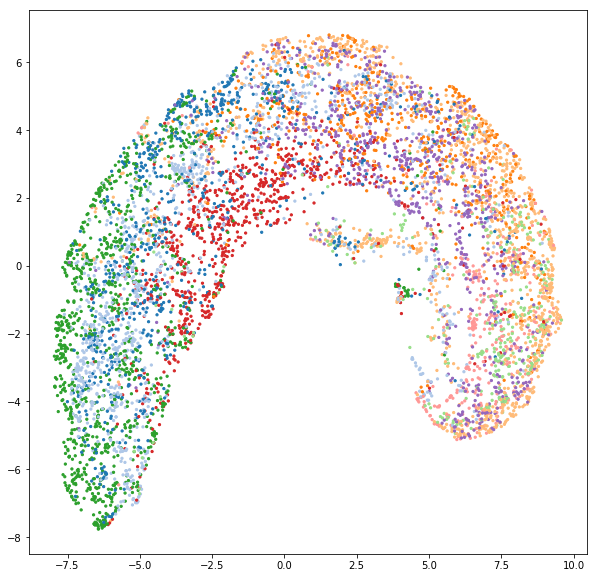

In [132]:
scatter_projections(projection=z, alpha=1, labels = subset_df.indv.values, s=5)